In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [6]:
def rosenbrock_func(x, y):
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

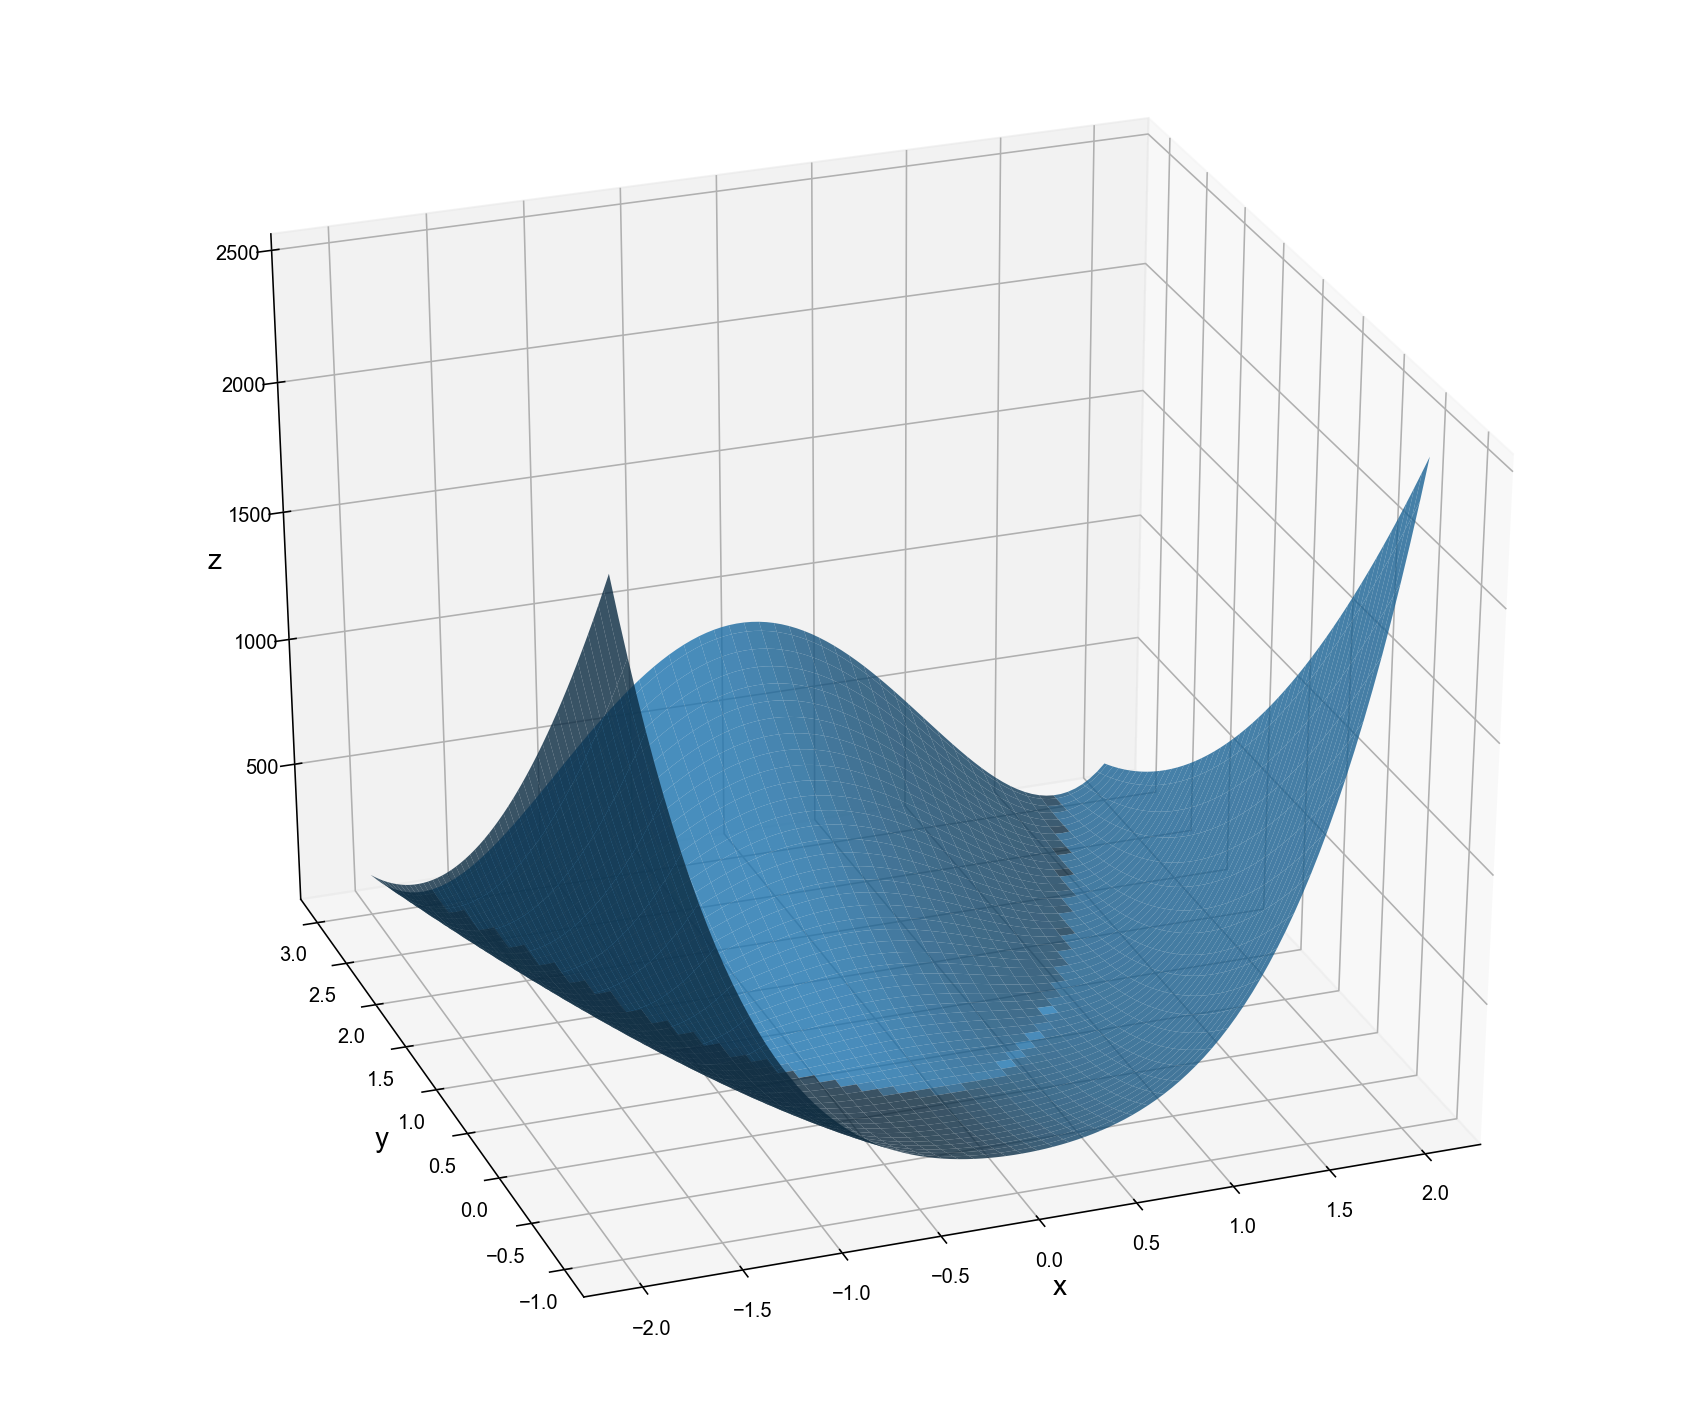

In [7]:
fig = plt.figure(figsize=(12,10))

# Make grid
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x, y)
Z = rosenbrock_func(X, Y)

# Plot the surface
ax = fig.add_subplot(1, 1, 1, projection='3d')
#norm = matplotlib.colors.Normalize(vmin = 0, vmax = 100, clip = True)
#ax.plot_surface(X, Y, Z, alpha=0.8, cmap='viridis_r', norm=norm)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
ax.view_init(30, 250)

sns.set()
sns.set_style("white")

plt.tight_layout()

In [8]:
fig.savefig("rosenbrock.png", bbox_inches='tight', dpi=600)

Определим функцию Розенброка:

In [15]:
def func(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2

Инициализируем метод роя частиц

In [16]:
class Particle:    
    def __init__(self, arg, search_space):
        self.pos = np.asarray([])      # расположение частицы
        self.velocity = np.asarray([]) # вектор скорости частицы
        self.pos_best = None           # лучшее расположение 
        
        for i in range(arg):
            pos_i = np.random.uniform(search_space[i][0], search_space[i][1])
            self.pos = np.append(self.pos, pos_i)
            vel_i = np.random.uniform(0.2 * search_space[i][0] , 0.2 * search_space[i][1])
            self.velocity = np.append(self.velocity, vel_i)
        
        # pos_best --- это список, состоящий из лучшего расположения частицы 
        # и значения функции в данной точке
        self.pos_best = [self.pos.copy(), func(self.pos)] 
    
    def update_position(self):
        self.pos += self.velocity
    
    def update_velocity(self, w, c1, c2, swarm_best):
        inertion = w * self.velocity
        cognitive_acceler = c1 * np.random.uniform() * (self.pos_best[0] - self.pos)
        social_acceler = c2 * np.random.uniform() * (swarm_best - self.pos)
        self.velocity = inertion + cognitive_acceler + social_acceler
    
    def choose_personal_best(self):
         if func(self.pos) < func(self.pos_best[0]):
                    self.pos_best[0] = self.pos.copy()
                    self.pos_best[1] = func(self.pos)

In [17]:
class ParticleSwarmOptimisation:
    def __init__(self, ell=40, w=1.0, c1=0.2, c2=0.2, max_iter=1000, tol=1e-6):
        """
        PARAMETERS:
        ell --- количество частиц в рое.
        w --- инерционный вес.
        c1 --- коэффициент ускорения когнитивного воздействия на частицу.
        c2 --- коэффициент ускорения социального воздействия на частицу.
        max_iter --- максимальное количество итераций.
        tol --- точность.
        """
        self.ell = ell
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.tol = tol
        
        self.swarm_best = None # лучшее расположение для всего роя
        self.swarm = None      # расположение всех частиц (рой)
        
    def search_global(self, arg, search_space):
        """
        PARAMETERS:
        arg --- количество аргументов функции.
        search_space --- область поиска оптимума. Задается как список из кортежей, где 
        кортеж --- это область значений одного аргумента функции.
        """
        self.arg = arg
        self.search_space = np.array(search_space)
        self.swarm = np.asarray([])
        
        # генерируем расположение роя 
        for _ in range(self.ell):
            self.swarm = np.append(self.swarm, 
                                   Particle(self.arg, self.search_space))
    
        for k in range(self.max_iter):
            for i in range(self.ell):
                # обновляем расположение частицы
                self.swarm[i].update_position()
                # сравниваем с лучшей точкой частицы
                self.swarm[i].choose_personal_best()
            
            # выбираем лучшую точку для роя
            if k != 0:
                dist_0 = self.dist(self.swarm_best[0])
                self.choose_social_best()
                dist_1 = self.dist(self.swarm_best[0])
                
                # останавливаем поиск в условиях заданной точности
                if (dist_0 != dist_1) and (abs(dist_0 - dist_1) <= self.tol):
                    break
            else:
                self.choose_social_best()
                
            # обновляем вектор скорости
            for i in range(self.ell):
                self.swarm[i].update_velocity(self.w, self.c1, self.c2, self.swarm_best[0])
        
        print(f"Глобальный оптимум: {self.swarm_best[0]}.")
        print(f"Значение функции в данной точке: {self.swarm_best[1]}.")
        
        
    def choose_social_best(self):
        self.swarm_best = min([[self.swarm[i].pos_best[0], 
                                self.swarm[i].pos_best[1]] for i in range(self.ell)],
                                key=lambda x: x[1])
        
    def dist(self, x):
        return np.sqrt(np.sum(x ** 2))

In [18]:
a = ParticleSwarmOptimisation(w=0.95, ell=100, tol=1e-20)

In [19]:
np.random.seed(53)
a.search_global(2, [(-10, 10),(-10, 10)])

Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 6.366439023928984e-22.


In [30]:
np.random.seed(53)
%timeit a.search_global(2, [(-10, 10),(-10, 10)])

Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 6.366439023928984e-22.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 5.942341366989282e-22.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 1.9539173742386574e-21.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 7.036545720598447e-25.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 2.5185902838094217e-22.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 2.218922834587525e-22.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 3.047063480508407e-23.
Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 1.1470615787355122e-20.
1.79 s ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для графиков

In [20]:
import copy

In [21]:
class ParticleSwarmOptimisation:
    def __init__(self, ell=40, w=1.0, c1=0.2, c2=0.2, max_iter=1000, tol=1e-6):
        """
        PARAMETERS:
        ell --- количество частиц в рое.
        w --- инерционный вес.
        c1 --- коэффициент ускорения когнитивного воздействия на частицу.
        c2 --- коэффициент ускорения социального воздействия на частицу.
        max_iter --- максимальное количество итераций.
        tol --- точность.
        """
        self.ell = ell
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.tol = tol
        
        self.swarm_best = None # лучшее расположение для всего роя
        self.swarm = None      # расположение всех частиц (рой)
        self.func_history = None # для графика
        self.x_0 = None
        self.x_50 = None
        self.x_100 = None
        self.x_150 = None
        self.x_300 = None
        self.x_999 = None
        self.v_0 = None
        self.v_50 = None
        self.v_100 = None
        self.v_150 = None
        self.v_300 = None
        self.v_999 = None
        
    def search_global(self, arg, search_space):
        """
        PARAMETERS:
        arg --- количество аргументов функции.
        search_space --- область поиска оптимума. Задается как список из кортежей, где 
        кортеж --- это область значений одного аргумента функции.
        """
        self.arg = arg
        self.search_space = np.array(search_space)
        self.swarm = np.asarray([])
        self.func_history = []
        self.x_0 = []
        
        
        # генерируем расположение роя 
        for _ in range(self.ell):
            self.swarm = np.append(self.swarm, 
                                   Particle(self.arg, self.search_space))
        # для графика 
        self.x_0 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
        self.v_0 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
        
        for k in range(self.max_iter):
            for i in range(self.ell):
                # обновляем расположение частицы
                self.swarm[i].update_position()
                # сравниваем с лучшей точкой частицы
                self.swarm[i].choose_personal_best()
            
            # выбираем лучшую точку для роя
            if k != 0:
                dist_0 = self.dist(self.swarm_best[0])
                self.choose_social_best()
                dist_1 = self.dist(self.swarm_best[0])
                
                # для графика
                self.func_history.append(func(self.swarm_best[0]))
                
                # останавливаем поиск в условиях заданной точности
                if (dist_0 != dist_1) and (abs(dist_0 - dist_1) <= self.tol):
                    break
            else:
                self.choose_social_best()
                # для графика
                self.func_history.append(func(self.swarm_best[0]))
            
            # для графика
            if k == 50:
                self.x_50 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
                self.v_50 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
                
            # для графика
            if k == 100:
                self.x_100 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
                self.v_100 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
                
            # для графика
            if k == 150:
                self.x_150 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
                self.v_150 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
                
            # для графика 
            if k == 300:
                self.x_300 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
                self.v_300 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
                
            # обновляем вектор скорости
            for i in range(self.ell):
                self.swarm[i].update_velocity(self.w, self.c1, self.c2, self.swarm_best[0])
        
        # для графика 
        self.x_999 = copy.deepcopy([self.swarm[i].pos for i in range(self.ell)])
        self.v_999 = copy.deepcopy([self.swarm[i].velocity for i in range(self.ell)])
        
        print(f"Глобальный оптимум: {self.swarm_best[0]}.")
        print(f"Значение функции в данной точке: {self.swarm_best[1]}.")
        
        
    def choose_social_best(self):
        self.swarm_best = min([[self.swarm[i].pos_best[0], 
                                self.swarm[i].pos_best[1]] for i in range(self.ell)],
                                key=lambda x: x[1])
        
    def dist(self, x):
        return np.sqrt(np.sum(x ** 2))

In [22]:
a = ParticleSwarmOptimisation(w=0.95, ell=100, tol=1e-20)

In [23]:
np.random.seed(53)
a.search_global(2, [(-10, 10),(-10, 10)])

Глобальный оптимум: [1. 1.].
Значение функции в данной точке: 6.366439023928984e-22.


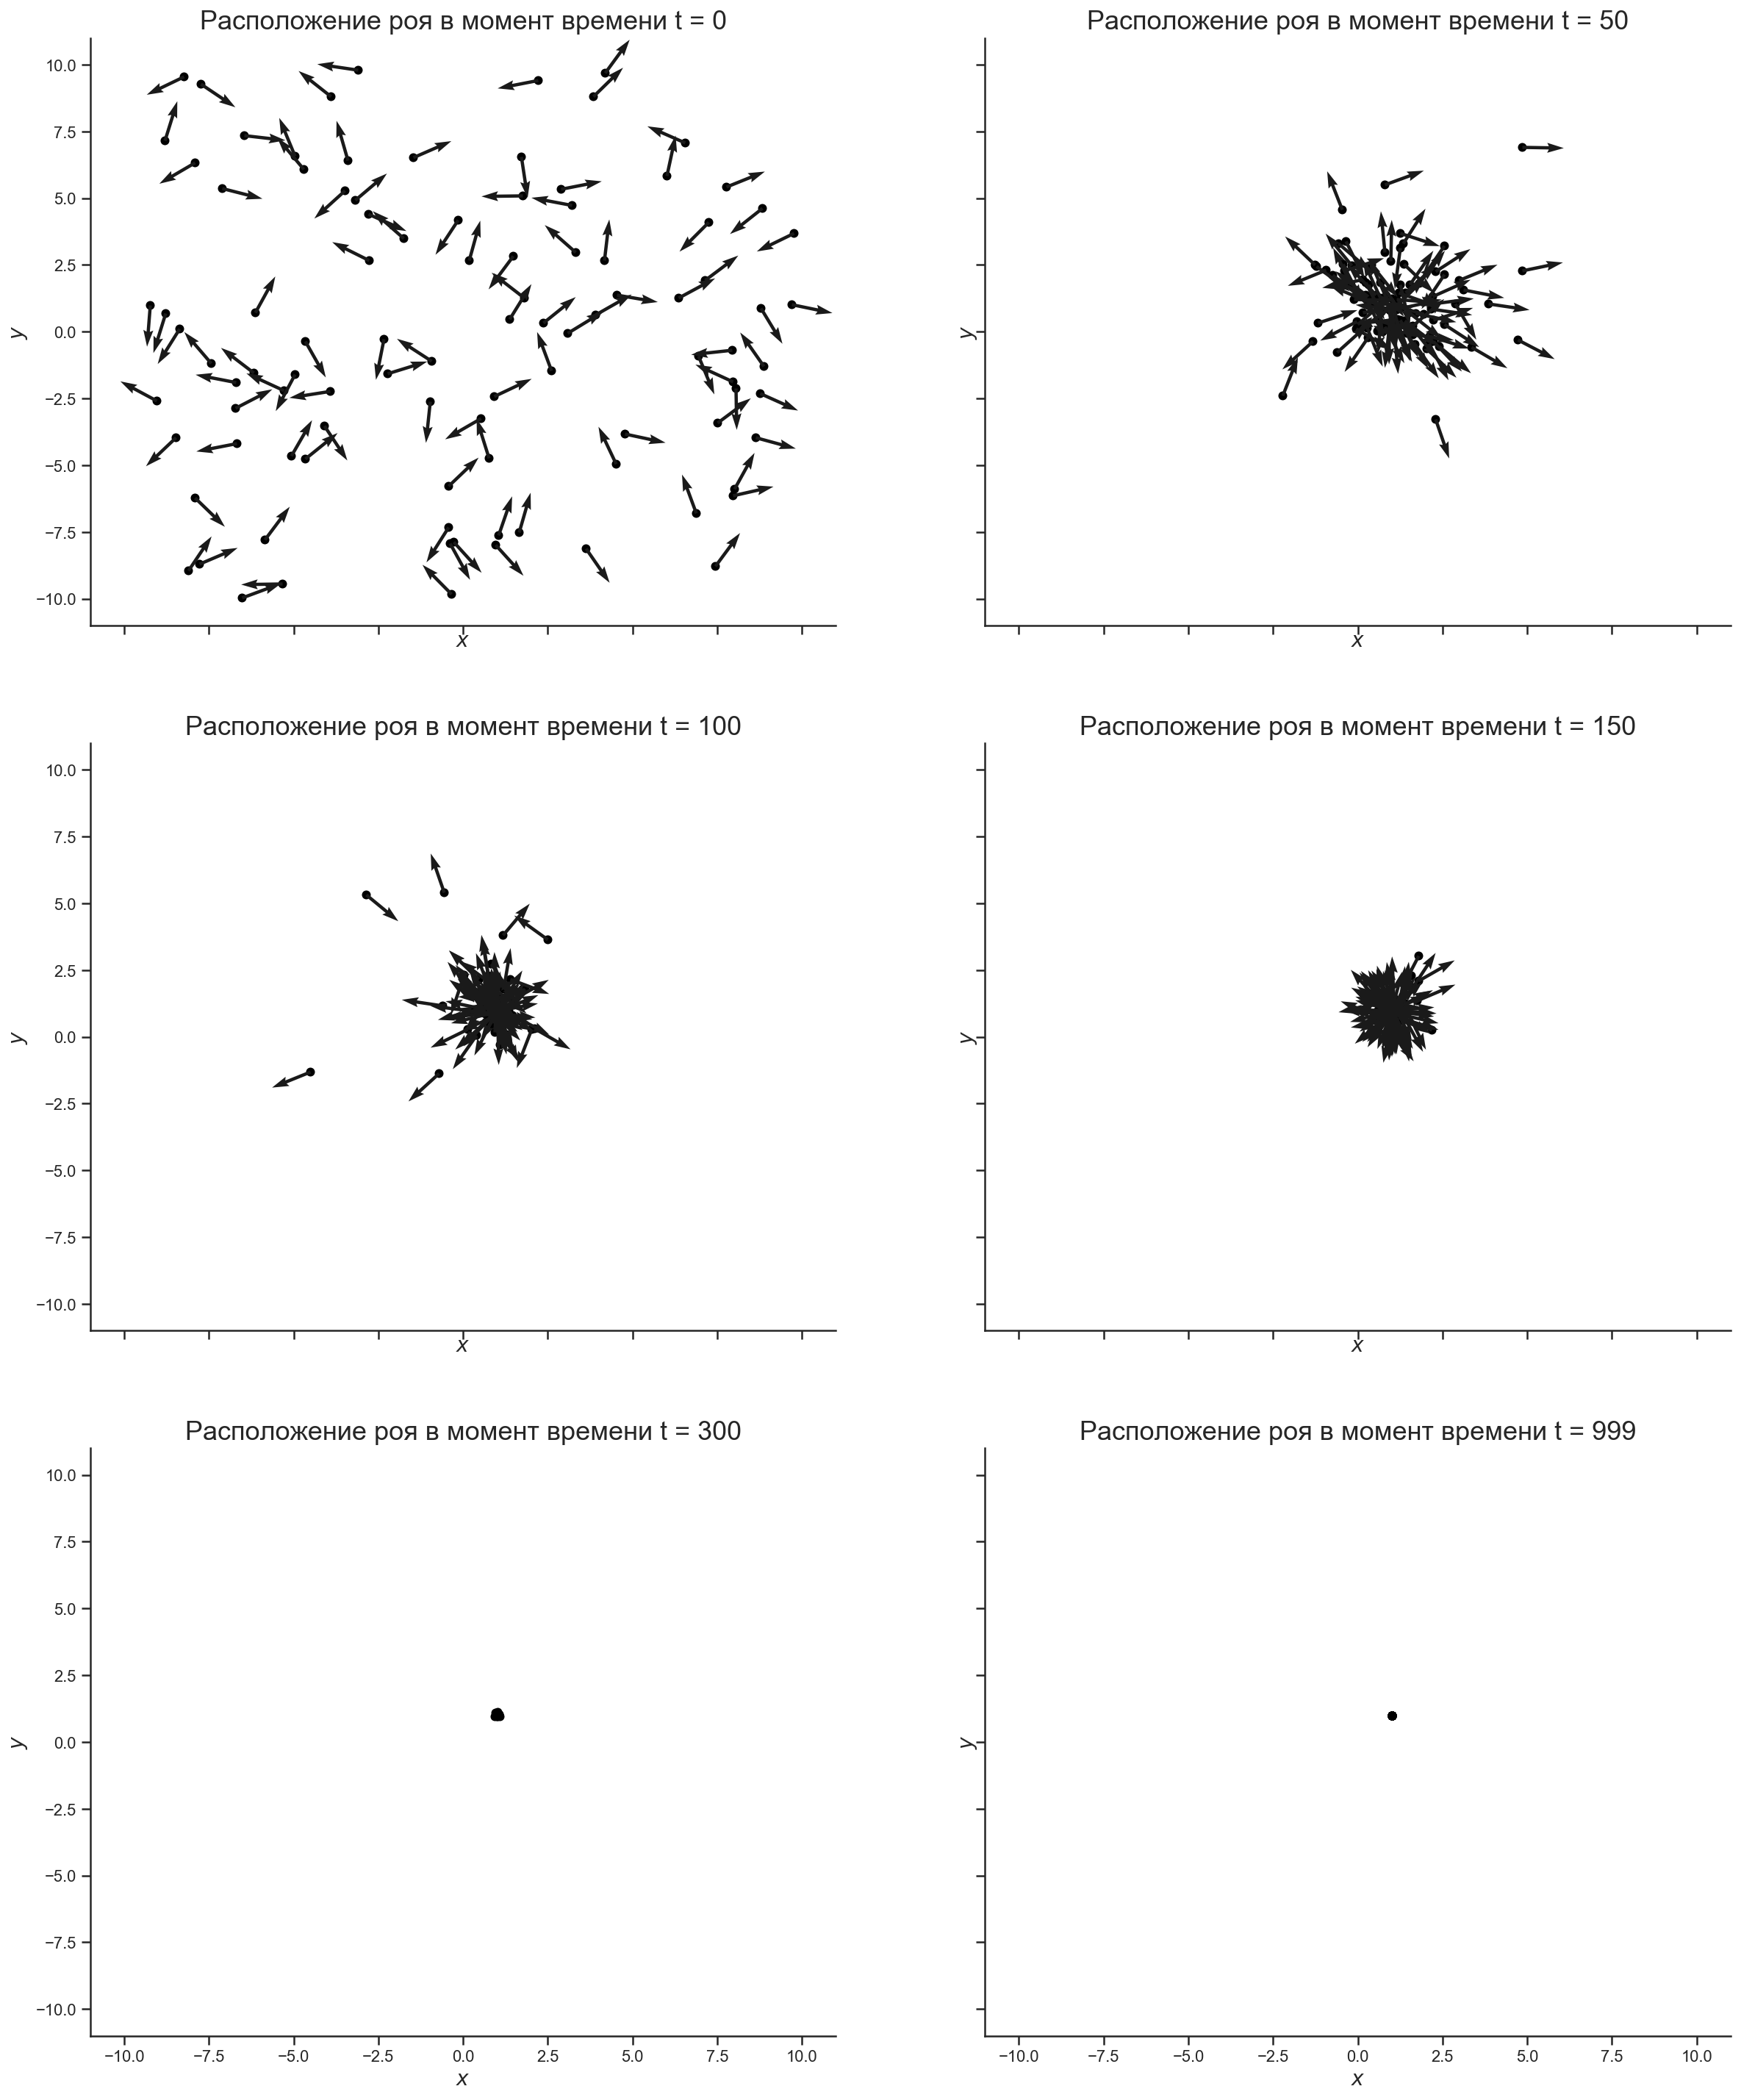

In [24]:
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(20, 25))

t = [0, 50, 100, 150, 300, 999]
swarm = [a.x_0, a.x_50, a.x_100, a.x_150, a.x_300, a.x_999]
velocity = [a.v_0, a.v_50, a.v_100, a.v_150, a.v_300, a.v_999]

sns.set()
sns.set_style("white")

z = 0
for i in range(3):
    for j in range(2):
        ax[i, j].set_title("Расположение роя в момент времени t = {}".format(t[z]), fontsize=18)
        ax[i, j].set_xlabel('$x$', fontsize=14)
        ax[i, j].set_ylabel('$y$', fontsize=14)
        ax[i, j].spines["top"].set_visible(False)  
        ax[i, j].spines["right"].set_visible(False)
        ax[i, j].get_xaxis().tick_bottom()
        ax[i, j].get_yaxis().tick_left() 
        ax[i, j].set_xlim(-11, 11)
        ax[i, j].set_ylim(-11, 11)
        
        xs = []
        ys = []
        
        for particle in swarm[z]:
            xs.append(particle[0])
            ys.append(particle[1])
        
        ax[i, j].scatter(xs, ys, marker="o", s=25, color='black')
        
        if t[z] < 300:
            for k in range(len(swarm[z])):
                ax[i,j].quiver(swarm[z][k][0], swarm[z][k][1], 
                               velocity[z][k][0] / np.sqrt(velocity[z][k][0] ** 2 + velocity[z][k][1] ** 2), 
                               velocity[z][k][1] / np.sqrt(velocity[z][k][0] ** 2 + velocity[z][k][1] ** 2),
                               scale_units='xy', minshaft=2.5) #color='#1f77b4'
                    
        z += 1

In [25]:
fig.savefig("swarm.png".format(t), bbox_inches='tight', dpi=600)

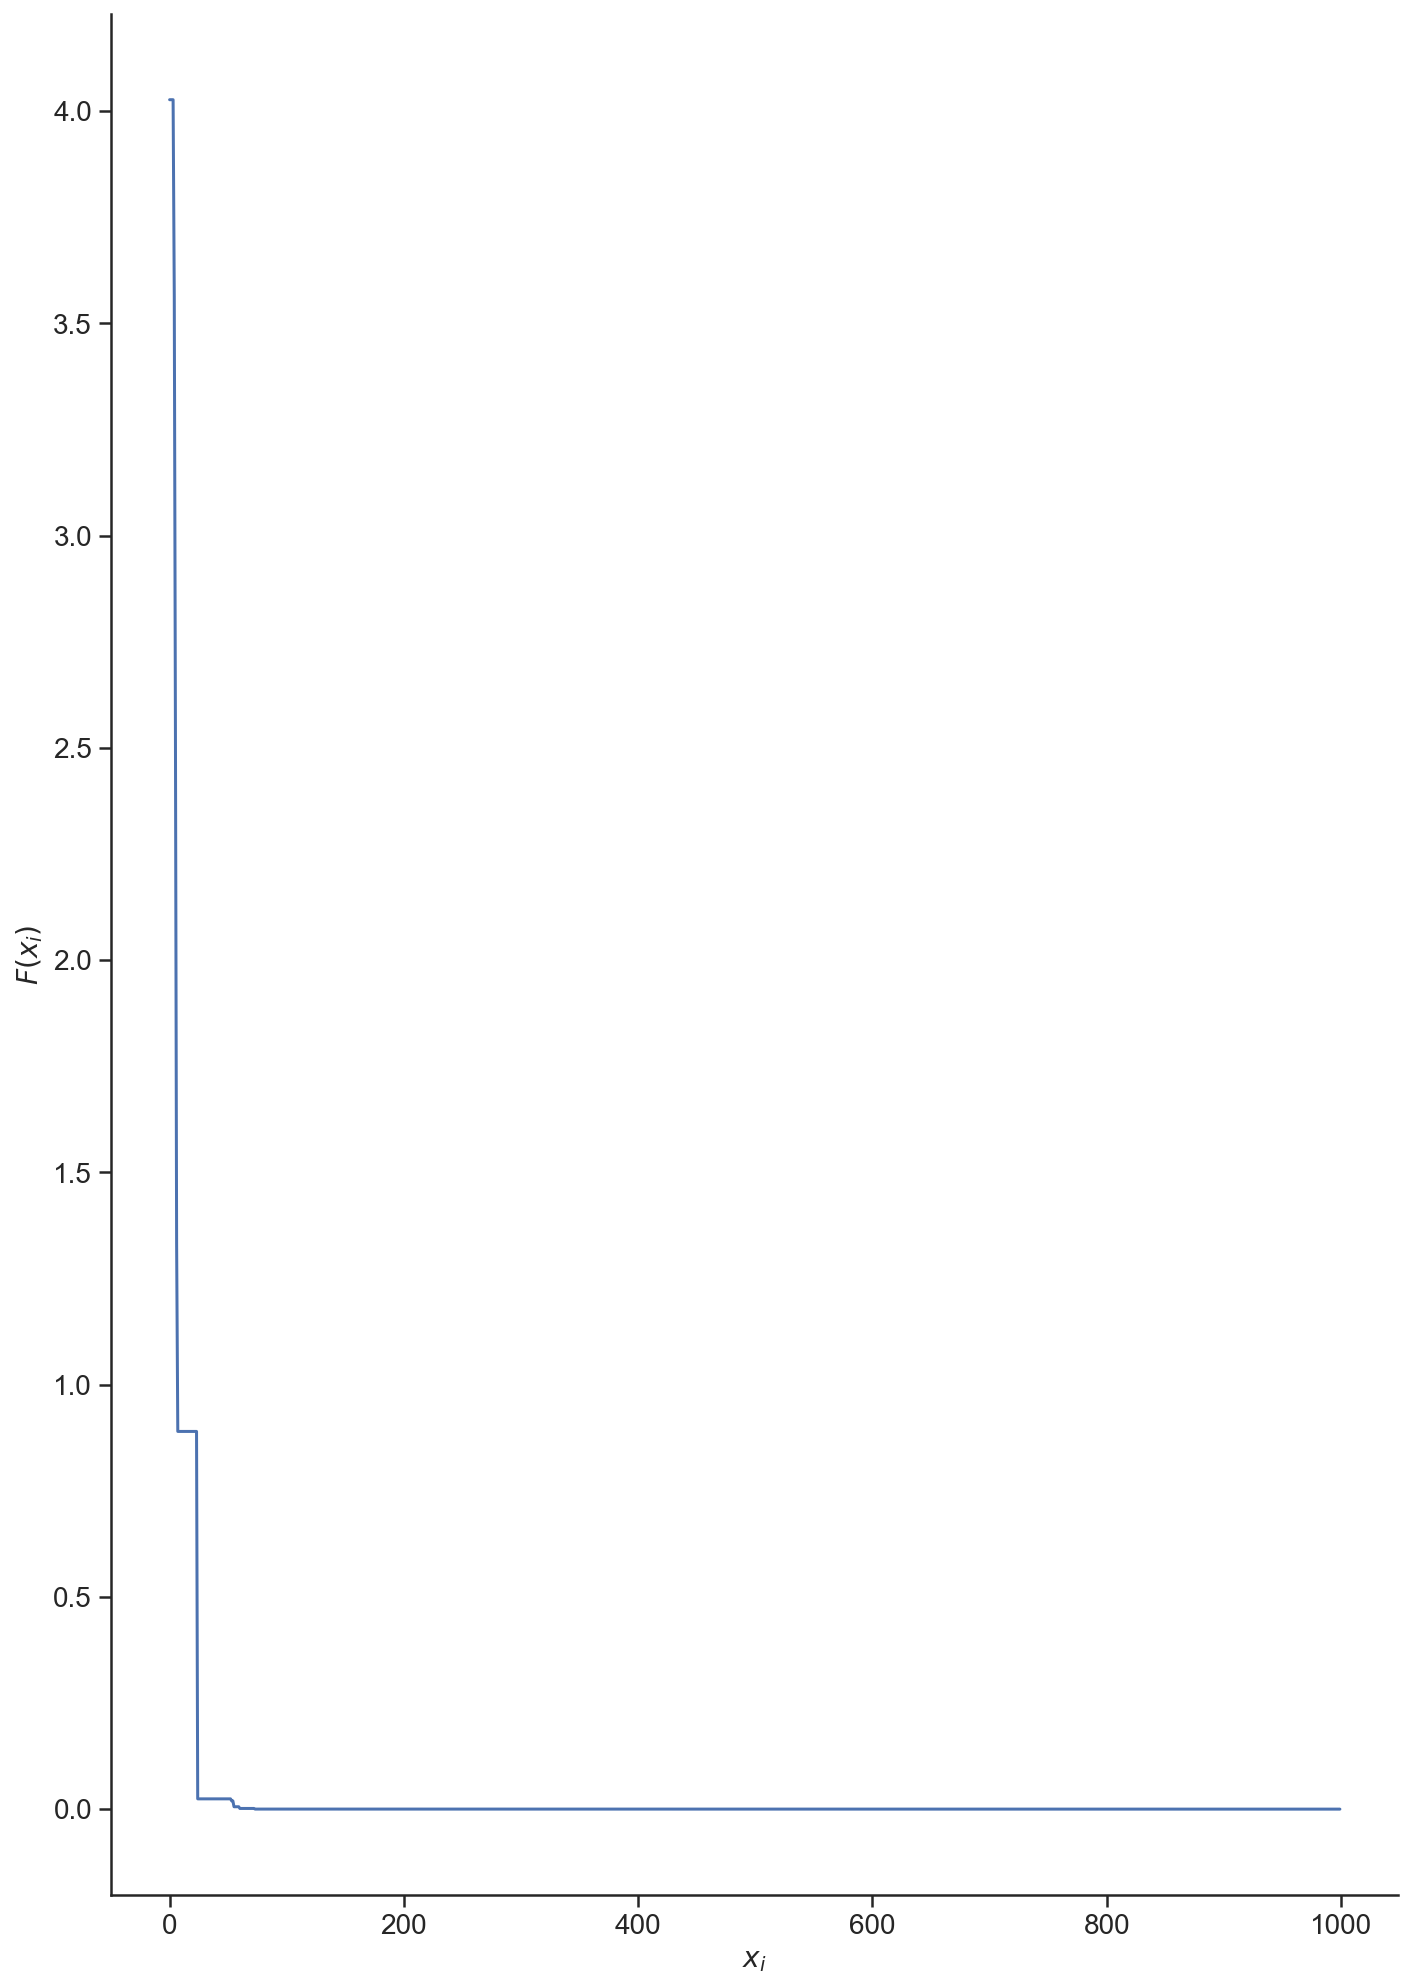

In [35]:
fig = plt.figure(figsize=(10, 14))
    
# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
    
# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
    
plt.xlabel("$x_i$", fontsize=14)  
plt.ylabel("$F(x_i)$", fontsize=14)
plt.plot(a.func_history)
plt.tight_layout()

sns.set()
sns.set_style("white")

fig.savefig("PSO_2.png", bbox_inches='tight', dpi=900)

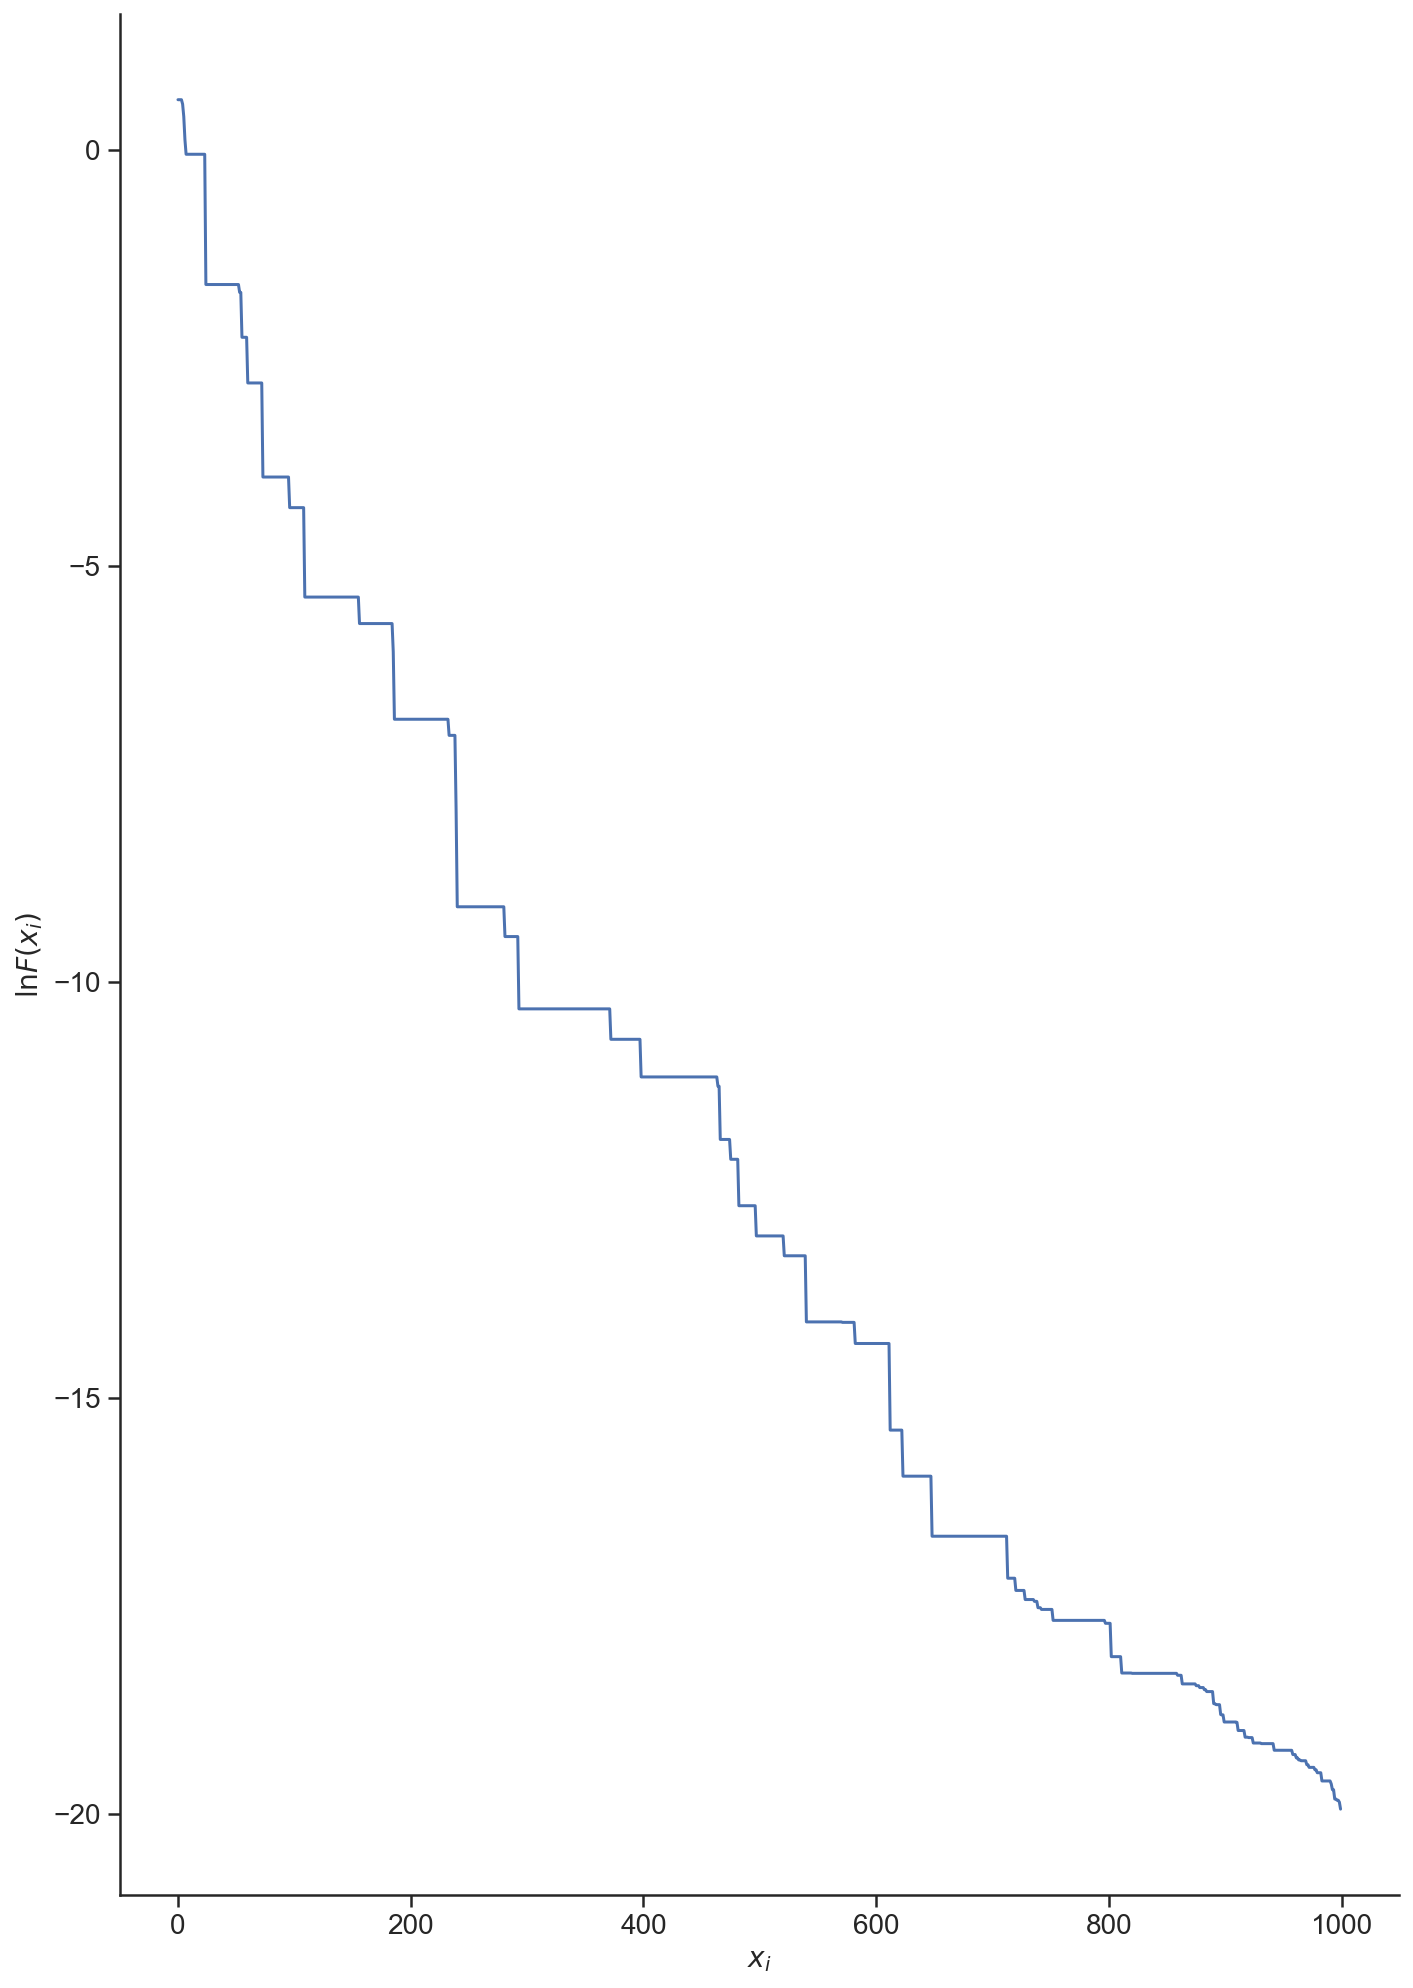

In [36]:
fig = plt.figure(figsize=(10, 14))

# Удаляем лишние границы
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
    
# Корректируем оси абсцисс и ординат
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 
    
plt.xlabel("$x_i$", fontsize=14)  
plt.ylabel("$\lnF(x_i)$", fontsize=14)
plt.plot(np.log10(a.func_history))
plt.tight_layout()

fig.savefig("PSO_3.png", bbox_inches='tight', dpi=900)